**Generate Grapths - Opendirectories**
-------

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib import dates
import matplotlib.pyplot as plt
from collections import Counter

In [3]:
import sys
cwd = sys.path[0]
cwd = './'

In [4]:
plt.style.available
plt.style.use('bmh')

In [5]:
df = pd.read_csv('{}/../subsets/SUBREDDIT_LINKS.csv'.format(cwd))

**1.0 Visualising All Subreddit Posts**

In [6]:
# Convert unix timecode to human readable date in the form (year-month)
df['TIME_%Y%M'] = df['TIME_GMT'].apply(lambda x: datetime.fromtimestamp(x).strftime('%Y-%m'))
# Group dates by (year-month)
df_posts = df['TIME_%Y%M'].value_counts()
# Order series by date
df_posts.sort_index(inplace=True)
# Remove latest month which is not complete yet
df_posts = df_posts[:-1]

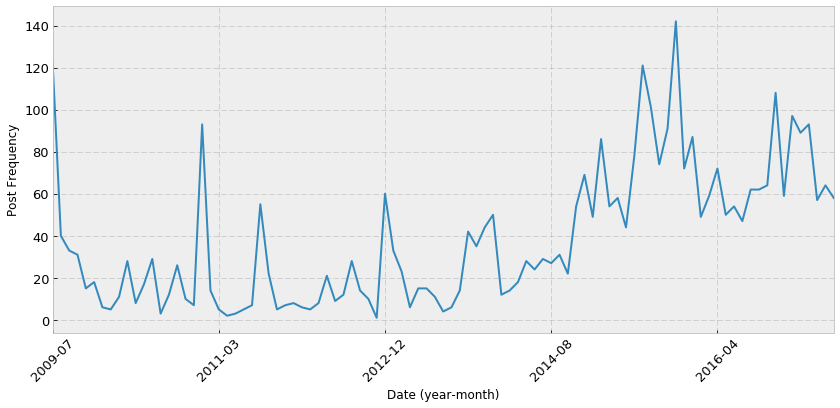

In [7]:
# Plot distribution
ax = df_posts.plot(figsize=(14, 6), rot=45, fontsize=13)
ax.set_xlabel('Date (year-month)')
ax.set_ylabel('Post Frequency')

In [8]:
# Save figure
fig=ax.get_figure()
fig.tight_layout()
fig.savefig('{}/../figs/POSTS_VS_TIME.png'.format(cwd))

**1.1 Most Common Open Directory Paths**

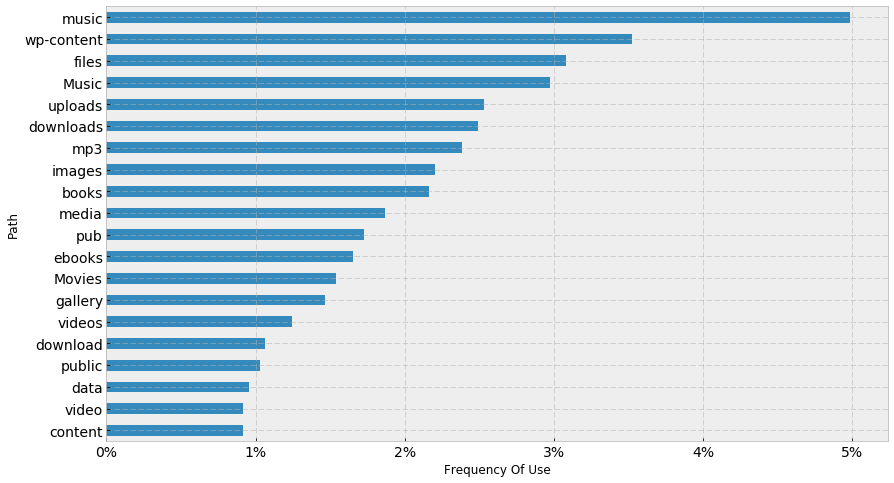

In [9]:
# Get paths and netlocations
ext = df[['PATH', 'NETLOC']].copy()
# Convert empty paths to null values
ext['PATH'] = ext['PATH'].map(lambda x: np.nan if x is '/' else x)
# Remove any entries which have a null value
ext.dropna(axis=0, how='any', inplace=True)
# Remove proxy extensions
ext['NETLOC'] = ext['NETLOC'].map(lambda x: x.replace('.nyud.net:8080', ''))
# Group paths by netlocation
gb = ext.groupby(('NETLOC'))
# Collect the results
ext = gb['PATH'].unique().values
# Measure total sample size
total_sampled_websites = len(ext)
# Split paths levels and only keep unique words per website
word_frequency = (set(word for subdomain in site for word in subdomain.split('/') if word) for site in ext)
# Perform a frequency analysis on the complete set of paths
freq_analysis = Counter([word for words in word_frequency for word in words])

# Normalise the results
for key in freq_analysis:
    freq_analysis[key] /= total_sampled_websites
    freq_analysis[key] *= 100

# Grab the top 20 most frequent paths
keys = [key for key, item in freq_analysis.most_common(20)]
items = [item for key, item in freq_analysis.most_common(20)]
series = pd.Series(data=items[::-1], index=keys[::-1])

# Plot results
ax = series.plot(kind='barh', figsize=(14, 8), fontsize=14)
ax.set_ylabel('Path')
ax.set_xlabel('Frequency Of Use')
ax.set_xticklabels(['{}%'.format(x) for x in ax.get_yticks()])

In [10]:
# Save figure
fig=ax.get_figure()
fig.tight_layout()
fig.savefig('{}/../figs/COMMON_PATHS.png'.format(cwd))

**1.1 Visualising Status Code Frequency**

In [11]:
# Get a frequency breakdown of status codes, null represents no connection
df_status = df['STATUS'].replace(np.nan, -1).astype(np.int)
df_status = df_status.replace(-1, 'null').value_counts()

# Normalise data
df_status = df_status.apply(lambda x: (x / df_status.sum()) * 100)

# Combine all codes which comprise < 1 % of total into other field
others_sum = df_status[(df_status < 1)].sum()
df_others = pd.Series([others_sum], index=['other'])

# Remove values which comprise less than 1% of the data.
df_status = df_status[(df_status >= 1)]

# Include 'others' section
df_status = df_status.append(df_others)

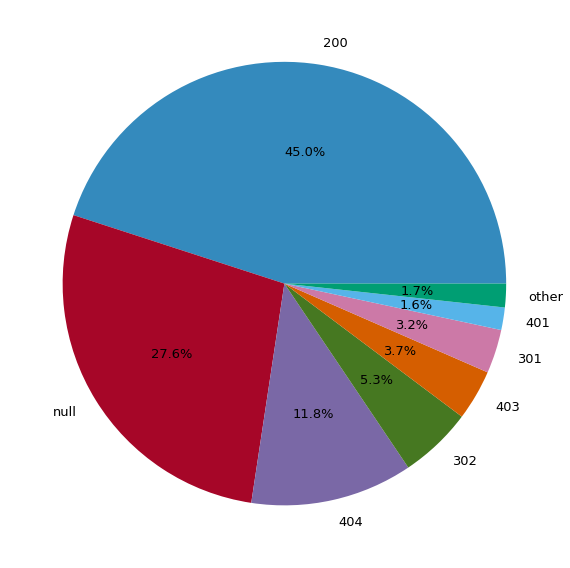

In [12]:
# Plot and save graph
ax = df_status.plot.pie(x=df_status.values,figsize=(14, 8),autopct='%0.1f%%', fontsize=13)
#ax.set_title('Server Status Code Distribution')
ax.set_ylabel('')
ax.set_aspect('equal')
fig=ax.get_figure()
fig.tight_layout()
fig.savefig('{}/../figs/STATUS_FREQUENCY.png'.format(cwd))

**1.2 Visualising Connection Status Over Time**

In [13]:
df = pd.read_csv('{}/../subsets/CONNECTION_ANALYTICS.csv'.format(cwd), index_col=0)

In [14]:
# Drop any status code where its historic contribution is always below 1%.
df = df[df  > 1].dropna(axis=1, how='all')

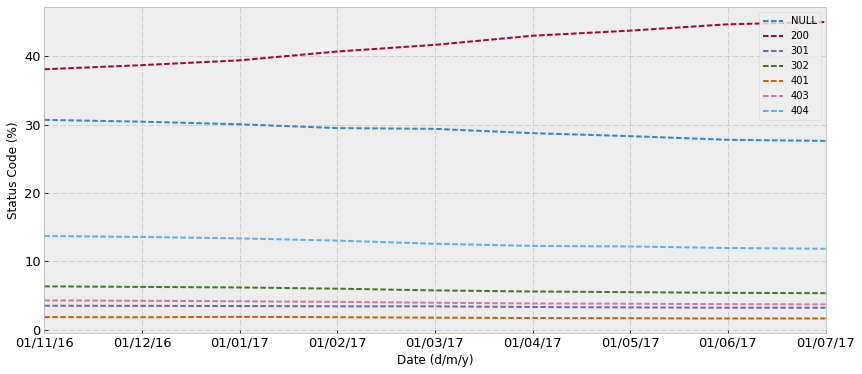

In [15]:
ax = df.plot(style='--', figsize=(14, 6), fontsize=13)
ax.set_ylabel('Status Code (%)')
ax.set_xlabel('Date (d/m/y)')

In [16]:
fig=ax.get_figure()
fig.tight_layout()
fig.savefig('{}/../figs/DATE_STATUS_HISTORIC.png'.format(cwd))